# Mount your Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
noise_std = 0.005
num_epochs = 300
batch_size = 16

num_features = 12
output_dim = 60
hidden_dim = 68
eps = 10

# Installations:

In [ ]:
import torch
from torch import Tensor
print(torch.__version__)

2.2.1+cu121


In [ ]:
# Install required packages.
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 72.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 44.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.2.1+cu121.html
ERROR: Could not find a version that satisfies the requirement pyg-lib (from versions: none)
ERROR: No matching distribution found for pyg-lib
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-rbhezowq
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-rbhezowq
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit beb9f7d70d20aa326de005d6f4e4cc6026d1c539
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for 

# Imports:

In [ ]:
import torch_geometric
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as Data
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx
#from torch_geometric.data import HeteroData

In [ ]:
import numpy as np
import torch
import pandas as pd

In [ ]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# Loading the data:

In [ ]:
!git clone https://github.com/MeysamAmirsardari/VAME

Cloning into 'VAME'...
remote: Enumerating objects: 1488, done.
remote: Counting objects: 100% (338/338), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 1488 (delta 283), reused 258 (delta 255), pack-reused 1150
Receiving objects: 100% (1488/1488), 109.84 MiB | 7.46 MiB/s, done.
Resolving deltas: 100% (888/888), done.
Updating files: 100% (45/45), done.


In [ ]:
import numpy as np
import pandas as pd

# !git clone https://github.com/MeysamAmirsardari/PoseModel

path = '/content/VAME/examples/mouse-1-2.csv'

num_keypoints = 6
num_layers = 60
epoch_len = 60
overlap = 0.5

df = pd.read_csv(path, index_col=None, header=0, encoding="utf-8")
temp = df.head(1).values.tolist()[0]

labels = []
for i in range(1, num_keypoints*3, 3):
  labels.append(temp[i])

df = pd.read_csv(path, index_col=None, header=1, encoding="utf-8").drop(index=range(2))

Xs = []
Ys = []
CLs = []

for l in labels:
  Xs.append(df[l].values.astype(float).tolist())
  Ys.append(df[l+'.1'].values.astype(float).tolist())
  CLs.append(df[l+'.2'].values.astype(float).tolist())

Xs = np.array(Xs)
Ys = np.array(Ys)
CLs = np.array(CLs)

weighted_mean = np.sum(Xs * CLs, axis=1) / np.sum(CLs, axis=1)
norm_Xs = (Xs - weighted_mean[:, np.newaxis])/350

weighted_mean = np.sum(Ys * CLs, axis=1) / np.sum(CLs, axis=1)
norm_Ys = (Ys - weighted_mean[:, np.newaxis])/720

<ipython-input-8-0a0c632733c3>:13: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, index_col=None, header=0, encoding="utf-8")
<ipython-input-8-0a0c632733c3>:20: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, index_col=None, header=1, encoding="utf-8").drop(index=range(2))


# Modeling the graph:

In [ ]:
Xs_cov = np.corrcoef(Xs)
Ys_cov = np.corrcoef(Ys)
edj_attr_matrix = (np.square(Ys_cov) + np.square(Xs_cov))/2
print(edj_attr_matrix.astype(np.double))

[[1.         0.71935583 0.78059655 0.65853062 0.65739632 0.59929064]
 [0.71935583 1.         0.89628635 0.96241943 0.95126601 0.89949145]
 [0.78059655 0.89628635 1.         0.86043674 0.86532502 0.81232369]
 [0.65853062 0.96241943 0.86043674 1.         0.966905   0.96646001]
 [0.65739632 0.95126601 0.86532502 0.966905   1.         0.97038312]
 [0.59929064 0.89949145 0.81232369 0.96646001 0.97038312 1.        ]]


In [ ]:
def set_nodes(Xs, Ys, CLs, off_idx, land_mark_num, epoch_len, encoders=None):
  x = torch.tensor([])

  for n in range(epoch_len):
    for i in range(land_mark_num):
      step = torch.tensor([[float(Xs[i, n + off_idx])],
                           [float(Ys[i, n + off_idx])],
                           [float(CLs[i, n + off_idx])]],
                          dtype=torch.float)
      x = torch.cat((x, step.T), dim=0)
  return x

In [ ]:
num_landmarks = num_keypoints

edge_index = []
edge_attr = []

# Connect each landmark to all other landmarks in the same layer
for layer in range(num_layers):
    start = layer * num_landmarks
    layer_edges = [(i, j) for i in range(start, start + num_landmarks) for j in range(start, start + num_landmarks) if i != j]
    layer_edges = [[edge[0], edge[1]] for edge in layer_edges]
    edge_index.extend(layer_edges)
    edge_attr.extend([edj_attr_matrix[i % num_landmarks, j % num_landmarks] for i, j in layer_edges])

# Connect each landmark to the same landmark in the next layer
for layer in range(num_layers - 1):
    start1 = layer * num_landmarks
    start2 = (layer + 1) * num_landmarks
    layer_edges = [[i, j] for i in range(start1, start1 + num_landmarks) for j in range(start2, start2 + num_landmarks) if i % num_landmarks == j % num_landmarks]
    edge_index.extend(layer_edges)
    edge_attr.extend([1 for _ in layer_edges])

edge_index = torch.tensor(edge_index).double().t().contiguous()
edge_attr = torch.tensor(edge_attr).unsqueeze(-1)


In [ ]:
len = df.shape[0]-1
graph_list = []
order = []
land_mark_num = num_keypoints
count = 0
step = 10

#edge_index, edge_attr = set_edges(epoch_len, land_mark_num)

for i in range(1, len-epoch_len, step):
  x = set_nodes(norm_Xs, norm_Ys, CLs, i, land_mark_num, epoch_len)
  data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
  graph_list.append(data)
  count = count + 1
  order.append((count, i))

graph_num = count

# Richening the data:

In [ ]:
def add_velocity(x, land_mark_num):
    num_frames = x.shape[0] // land_mark_num
    velocities = torch.zeros(x.shape[0], 2)
    prev_poses = x[0:land_mark_num, :2]
    for i in range(num_frames):
        node_positions = x[i * land_mark_num : (i + 1) * land_mark_num, :2]
        pairwise_velocities = node_positions - prev_poses
        velocities[i*land_mark_num:(i+1)*land_mark_num, :] = pairwise_velocities
    return torch.cat([x, velocities], dim=1)

def add_acceleration(x, land_mark_num):
    num_frames = x.shape[0] // land_mark_num
    acc = torch.zeros(x.shape[0], 2)
    prev_poses = x[0:land_mark_num, 3:5]
    for i in range(num_frames):
        node_positions = x[i*land_mark_num:(i+1)*land_mark_num, 3:5]
        pairwise_acc = node_positions - prev_poses
        acc[i*land_mark_num:(i+1)*land_mark_num, :] = pairwise_acc
    return torch.cat([x, acc], dim=1)

def add_distances(x, land_mark_num):
    len = x.shape[0]
    num_frames = len // land_mark_num
    distances = torch.zeros(len, land_mark_num-1)
    pairwise_distances = torch.zeros(land_mark_num, land_mark_num-1)
    for n in range(num_frames):
      node_positions = x[n*land_mark_num:(n+1)*land_mark_num, :2]
      for i in range(land_mark_num):
        c = 0
        for j in range(land_mark_num):
          if i != j:
            diff = node_positions[i,:] - node_positions[c,:]
            pairwise_distances[i,c] = torch.sqrt(torch.sum(diff**2))
            c += 1
    distances[n*land_mark_num:(n+1)*land_mark_num, :] = pairwise_distances
    return torch.cat([x, distances], dim=1)

def add_features_to_x(x, land_mark_num):
  out = add_velocity(x, land_mark_num)
  out = add_acceleration(out, land_mark_num)
  out = add_distances(out, land_mark_num)
  return out

graph_list2 = []
for i in range(graph_num):
    g = graph_list[i]
    g.x = add_features_to_x(g.x, land_mark_num)
    graph_list2.append(g)

In [ ]:
print(graph_list[10].x.shape)

torch.Size([360, 12])


In [ ]:
dataloader = DataLoader(graph_list, batch_size=32, shuffle=True)
torch.save(dataloader, '/content/drive/MyDrive/new_const_test/rich_dataloader_mouse_1_2_12features.pth')

In [ ]:
# Load the saved dataloader
dataloader = torch.load('/content/drive/MyDrive/new_const_test/rich_dataloader_mouse_1_2_12features.pth')

In [ ]:
import networkx as nx

def calculate_graphical_features(edge_index, edge_attr, num_nodes):
    G = nx.Graph()
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i].tolist()
        attr = edge_attr[i].item()
        G.add_edge(src, dst, weight=attr)

    degree_centrality = np.array(list(nx.degree_centrality(G).values()))
    closeness_centrality = np.array(list(nx.closeness_centrality(G).values()))
    betweenness_centrality = np.array(list(nx.betweenness_centrality(G).values()))

    return degree_centrality, closeness_centrality, betweenness_centrality


def add_graphical_features(x, edge_index, edge_attr):
    num_nodes = x.shape[0] // 6
    degree_centrality, closeness_centrality, betweenness_centrality = calculate_graphical_features(edge_index, edge_attr, num_nodes)

    degree_centrality = torch.tensor(degree_centrality).float().view(-1, 1)
    closeness_centrality = torch.tensor(closeness_centrality).float().view(-1, 1)
    betweenness_centrality = torch.tensor(betweenness_centrality).float().view(-1, 1)

    graphical_features = torch.cat([degree_centrality, closeness_centrality, betweenness_centrality], dim=1)
    richer_features = torch.cat([x, graphical_features], dim=1)

    return richer_features

graph_list3 = []
for i in range(graph_num):
    g = graph_list2[i]
    g.x = add_graphical_features(g.x, g.edge_index, g.edge_attr)
    graph_list3.append(g)

In [ ]:
graph_list[10].x.shape

torch.Size([720, 7])

# Training the Attentional Variational Graph Autoencoder:

**Model: MultiHead Transormer**

**Encoder: GAT-50**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, VGAE, GMMConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GAE, VGAE, GCNConv, TransformerConv
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import global_mean_pool
import numpy as np


# Define the number of dimensions in the latent variable
hidden_dim = hidden_dim
output_dim = output_dim
input_dim = num_features

# Define the device to use for training (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the encoder and decoder architectures for the VAE

class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_gmm_layers=1):
        super(Encoder, self).__init__()
        torch.manual_seed(12345)
        self.gat1 = GATConv(input_dim, hidden_dim)
        self.gat2 = GATConv(hidden_dim, hidden_dim)
        self.gat3 = GATConv(hidden_dim, hidden_dim)
        self.gmm_layers = torch.nn.ModuleList()

        for i in range(num_gmm_layers):
            self.gmm_layers.append(GMMConv(hidden_dim, hidden_dim, kernel_size=10, dim=1))

        self.conv_mu = GCNConv(hidden_dim, hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_mean = torch.nn.Linear(hidden_dim, output_dim)
        self.lin_logstd = torch.nn.Linear(hidden_dim, output_dim)
        self.global_pool = torch.nn.Linear(hidden_dim, output_dim)


    def forward(self, x, edge_index, edge_attr, batch):
        x = self.gat1(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        x = self.gat3(x, edge_index, edge_attr=edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.4, training=self.training)

        for gmm_layer in self.gmm_layers:
          x = gmm_layer(x, edge_index, edge_attr)
          x = F.elu(x)
          x = F.dropout(x, p=0.4, training=self.training)

        # x = self.gat2(x, edge_index, edge_attr=edge_attr)
        # x = F.elu(x)
        # x = F.dropout(x, p=0.4, training=self.training)

        # x = self.gat2(x, edge_index, edge_attr=edge_attr)
        # x = F.elu(x)
        # x = F.dropout(x, p=0.4, training=self.training)

        # x = global_add_pool(x, batch)
        # x, batch = to_dense_batch(x, batch=batch)

        x = self.conv_mu(x, edge_index)

        x = F.dropout(x, p=0.4, training=self.training)
        z = global_mean_pool(x, batch)
        # x = self.global_pool(x)
        z = self.lin(z)
        z_log_std = self.lin_logstd(x)
        z_mean = self.lin_mean(x)

        return z, z_mean, z_log_std

**Encoder: GAT+bn+sp**

**Decoder and Loss Func:**

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.lin1 = torch.nn.Linear(input_dim, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.lin3 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, z, edge_index, edge_attr):
        z = self.lin1(z)
        z = F.relu(z)
        z = self.conv1(z, edge_index)
        z = F.relu(z)
        z = self.conv2(z, edge_index)
        z = F.relu(z)
        z = self.lin3(z)
        z = torch.sigmoid(z)
        return z


class AttentionalGraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AttentionalGraphAutoencoder, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, output_dim)
        self.decoder = Decoder(output_dim, hidden_dim, input_dim)

    def forward(self, x, edge_index, edge_attr, batch):
        z, z_mean, z_log_std = self.encoder(x, edge_index, edge_attr, batch)
        z = z_mean + torch.randn_like(z_log_std) * torch.exp(0.5 * z_log_std)
        x_hat = self.decoder(z, edge_index, edge_attr)
        return x_hat, z_mean, z_log_std

def loss_function(x_hat, z_mean, x, z_log_std):
    # kl_loss = 0#0.5 * torch.sum(z_log_std - output**2 - 1, dim=1)
    kl_loss = -0.5 * torch.sum(1 + z_log_std - z_mean.pow(2) - z_log_std.exp())
    recon_loss = F.mse_loss(x_hat, x)
    print(kl_loss)
    print(recon_loss)
    loss = recon_loss + eps*kl_loss
    return loss
# def loss_function(x_hat, x, z_mean, z_log_std, alpha):
#     kl_loss = 0.5 * torch.sum(z_log_std + torch.exp(z_log_std) - z_mean**2 - 1, dim=1)
#     recon_loss = F.mse_loss(x_hat, x)
#     loss = recon_loss + alpha * kl_loss
#     return loss

def kl_loss(z_mean, z_log_std):
    kl_div = -0.5 * torch.sum(1 + 2*z_log_std - z_mean.pow(2) - (2*z_log_std).exp(), dim=1)
    return torch.mean(kl_div)


**Training the model:**

In [ ]:
import torch_geometric.utils as utils

train_losses = []
val_losses = []
train_accs = []
val_accs = []
loss_list = []

# Define the number of epochs to train for
num_epochs = num_epochs

# Define the batch size for the dataloader
batch_size = batch_size

# Define the number of nodes and features in each node
num_nodes = num_keypoints*num_layers
num_features = num_features

# Define the number of dimensions in the latent variable
noise_std = noise_std

dataloader = DataLoader(graph_list, batch_size=batch_size, shuffle=True)

# Initialize the attentional graph autoencoder model and move it to the device
model = AttentionalGraphAutoencoder(input_dim, hidden_dim, output_dim).to(device)

# Define the optimizer for the VAE
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0

    for batch in dataloader:
        batch = batch.to(device)

        noisy_input = batch.x + torch.randn_like(batch.x) * noise_std

        optimizer.zero_grad()

        x_hat, z_mean, z_log_std = model(noisy_input, batch.edge_index.long(), batch.edge_attr.long(), batch.batch)

        recon_loss = F.mse_loss(x_hat, batch.x)
        kl_div_loss = kl_loss(z_mean, z_log_std)
        # print(kl_div_loss)
        # print(recon_loss)
        loss = 1 * recon_loss + 0.1 * kl_div_loss

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch.num_graphs
    train_loss /= graph_num
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}: Loss={loss.item()}')
    loss_list.append(loss.item())

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/450: Loss=0.07742951065301895
Epoch 2/450: Loss=0.06878653913736343
Epoch 3/450: Loss=0.13656051456928253
Epoch 4/450: Loss=0.08776410669088364
Epoch 5/450: Loss=0.11489345878362656
Epoch 6/450: Loss=0.07394059002399445
Epoch 7/450: Loss=0.0928741842508316
Epoch 8/450: Loss=0.10433053225278854
Epoch 9/450: Loss=0.06541787087917328
Epoch 10/450: Loss=0.0915590226650238
Epoch 11/450: Loss=0.06695310771465302
Epoch 12/450: Loss=0.059679705649614334
Epoch 13/450: Loss=0.045173466205596924
Epoch 14/450: Loss=0.0679473876953125
Epoch 15/450: Loss=0.09091003239154816
Epoch 16/450: Loss=0.08559637516736984
Epoch 17/450: Loss=0.06741220504045486
Epoch 18/450: Loss=0.08798668533563614
Epoch 19/450: Loss=0.06415415555238724
Epoch 20/450: Loss=0.10230343043804169
Epoch 21/450: Loss=0.09601713716983795
Epoch 22/450: Loss=0.04636674001812935
Epoch 23/450: Loss=0.07024048268795013
Epoch 24/450: Loss=0.06430590152740479
Epoch 25/450: Loss=0.05657384544610977
Epoch 26/450: Loss=0.08205875754356

**Cleaning the memory!**

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

# Evaluation:

In [ ]:
output = model.encoder(graph_list[0].x, graph_list[0].edge_index.long(), graph_list[0].edge_attr, graph_list[0].batch)

In [ ]:
output[0]

In [ ]:
from torchsummary import summary

summary(model, (3, 2100, 16700))

In [ ]:
model.eval()

AttentionalGraphAutoencoder(
  (encoder): Encoder(
    (gat1): GATConv(12, 84, heads=1)
    (gat2): GATConv(84, 84, heads=1)
    (gat3): GATConv(84, 84, heads=1)
    (gmm_layers): ModuleList(
      (0): GMMConv(84, 84, dim=1)
    )
    (conv_mu): GCNConv(84, 84)
    (lin): Linear(in_features=84, out_features=36, bias=True)
    (lin_mean): Linear(in_features=84, out_features=36, bias=True)
    (lin_logstd): Linear(in_features=84, out_features=36, bias=True)
    (global_pool): Linear(in_features=84, out_features=36, bias=True)
  )
  (decoder): Decoder(
    (lin1): Linear(in_features=36, out_features=84, bias=True)
    (conv1): GCNConv(84, 84)
    (conv2): GCNConv(84, 84)
    (lin2): Linear(in_features=84, out_features=84, bias=True)
    (conv3): GCNConv(84, 84)
    (lin3): Linear(in_features=84, out_features=12, bias=True)
  )
)

**To save the trained model:**

In [ ]:
state_dict = model.state_dict()

# Save the state dictionary to a file
torch.save(state_dict, '/content/drive/MyDrive/new_const_test/mouse1_2_data_test_GAT2_GMM1_450_3_31_fine.pt')

**Loading the saved model:**

In [ ]:
model = AttentionalGraphAutoencoder(input_dim, hidden_dim, output_dim).to(device)

# Load the saved state dictionary into the model
state_dict = torch.load('/content/drive/MyDrive/new_const_test/mouse1_2_data_test_GAT2_GMM1_300_3_29_fine.pt', map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

# Embedding the graphs and saving:

In [ ]:
# Embed the input graphs using the trained VAE
embeddings = []

for graph in graph_list:
    graph = graph.to(device)
    with torch.no_grad():
        output = model.encoder(graph.x, graph.edge_index.long(), graph.edge_attr.long(), graph.batch)
    embeddings.append(output[0].cpu().numpy())

embeddings = np.array(embeddings)

In [ ]:
embeddings = embeddings[:,0,:]

In [ ]:
np.save('/content/drive/MyDrive/new_const_test/mouse1_2_data_test_GAT1_GMM2_450_3_31_fine.npy', embeddings)

Reload:

In [ ]:
embeddings = np.load('/content/drive/MyDrive/new_const_test/rich_vame_data_test_GAT3_300_3_24_fine.npy')
# embedded_3d = np.load('/content/drive/MyDrive/node_embeddings_3D.npy')

In [ ]:
embeddings2 = np.array(embeddings)

Visualizing the embedded data:

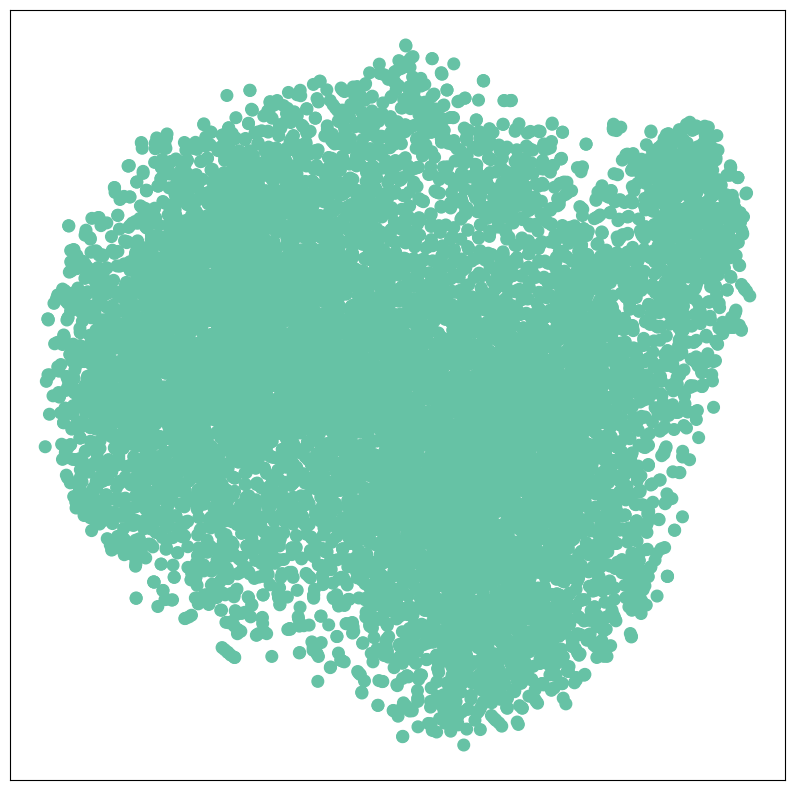

In [ ]:
visualize(torch.tensor(embeddings2), color=np.zeros([1,embeddings2.shape[0]]))

# Clustering the Graphs:

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture

# Load the embedded graph data
# embeddings = np.load('embeddings.npy')

# Set the number of clusters
num_clusters = 10

# Initialize the GMM model
gmm = GaussianMixture(n_components=num_clusters)

# Fit the GMM model to the embedded data
gmm.fit(embeddings2)

# Predict the cluster labels for the embedded data
cluster_labels = gmm.predict(embeddings2)
print(cluster_labels)

[0 0 0 ... 0 0 0]


In [ ]:
from sklearn.mixture import BayesianGaussianMixture


# Number of clusters you want to fit
num_clusters = 8  # Adjust this based on your requirements

# Fit a Gaussian Mixture Model
gmm = BayesianGaussianMixture(n_components=num_clusters, random_state=42)
gmm.fit(embeddings2)

# Extract the cluster centers (means)
cluster_centers = gmm.means_
cluster_labels = gmm.predict(embeddings2)

# Print the cluster centers
print("Cluster Centers:")
print(cluster_centers)

# Save cluster centers to a CSV file

np.savetxt('cluster_centers.csv', cluster_centers, delimiter=',', comments='')
np.savetxt('samples_labels.csv', cluster_labels, delimiter=',', comments='')

# print(f"Cluster centers saved to {csv_filename}.")


In [ ]:
!pip install -q hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 94.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import hdbscan

# Assuming your 6x1000 array is called `embedded_graph`
# Transpose the array so that each row represents a data point and each column represents a feature
embedded_graph = embeddings2

# Cluster the data using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels2 = clusterer.fit_predict(embedded_graph)

# Print the number of clusters found
# num_clusters = len(set(cluster_labels2)) - (1 if -1 in cluster_labels2 else 0)
print(f"Number of clusters: {num_clusters}")

# Print the cluster labels for each data point
print("Cluster labels:")
print(cluster_labels2)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# Load the embedded graph data
# embeddings = np.load('embeddings.npy')

# Set the number of clusters
num_clusters = 10

# Initialize the KMeans model
kmeans = KMeans(n_clusters=num_clusters)

# Fit the KMeans model to the embedded data
kmeans.fit(embeddings2)

# Predict the cluster labels for each data point
cluster_labels = kmeans.predict(embeddings2)

# Print the cluster labels
print(cluster_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 9 8 ... 3 8 0]


In [ ]:
cluster_centers = kmeans.means_

# Print the cluster centers
print("Cluster Centers:")
print(cluster_centers)

# Save cluster centers to a CSV file

np.savetxt('cluster_centers.csv', cluster_centers, delimiter=',', comments='')
np.savetxt('samples_labels.csv', cluster_labels, delimiter=',', comments='')

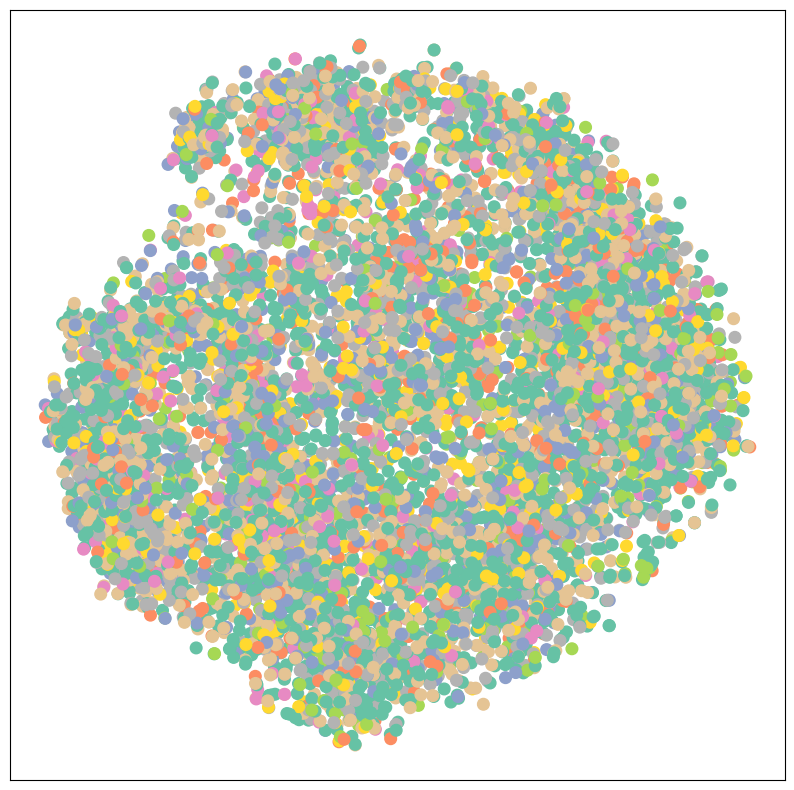

In [ ]:
visualize(torch.tensor(embeddings2), color=cluster_labels)



# Analysis:

transition matrix:

In [ ]:
states = cluster_labels
# Get unique state values
unique_states = np.unique(cluster_labels)

# Calculate the size of the transition matrix
matrix_size = 10

# Create an empty transition matrix
transition_matrix = np.zeros((matrix_size, matrix_size))

# Calculate the number of transitions between each pair of states
for i in range(graph_num - 1):
    current_state = states[i]
    next_state = states[i + 1]
    current_state_index = np.where(unique_states == current_state)[0][0]
    next_state_index = np.where(unique_states == next_state)[0][0]
    transition_matrix[current_state_index][next_state_index] += 1

# Normalize the transition matrix
row_sums = np.sum(transition_matrix, axis=1)
transition_matrix = np.divide(transition_matrix, row_sums[:, np.newaxis])

print(transition_matrix)

[[0.1959935  0.11802924 0.0790471  0.09853817 0.06334597 0.14564158
  0.0790471  0.11207363 0.02598809 0.08229561]
 [0.20413923 0.13170273 0.07619944 0.09783631 0.04797742 0.1476952
  0.08372531 0.09689558 0.02822201 0.08560677]
 [0.20700152 0.11872146 0.07762557 0.08219178 0.06392694 0.14003044
  0.10502283 0.09741248 0.02130898 0.08675799]
 [0.20283019 0.10849057 0.06367925 0.09669811 0.0495283  0.16509434
  0.06957547 0.11320755 0.03773585 0.09316038]
 [0.18544194 0.09878683 0.06759099 0.08665511 0.09532062 0.11091854
  0.09705373 0.10051993 0.0779896  0.0797227 ]
 [0.20507246 0.13768116 0.06956522 0.07753623 0.04927536 0.15217391
  0.08043478 0.09927536 0.02971014 0.09927536]
 [0.19667944 0.11621967 0.06768838 0.08684547 0.06257982 0.14559387
  0.0945083  0.10983397 0.02809706 0.09195402]
 [0.21921922 0.09309309 0.06206206 0.08408408 0.06106106 0.14614615
  0.08508509 0.11811812 0.04704705 0.08408408]
 [0.13559322 0.07062147 0.05367232 0.0819209  0.11581921 0.13276836
  0.06497175 

histogram:

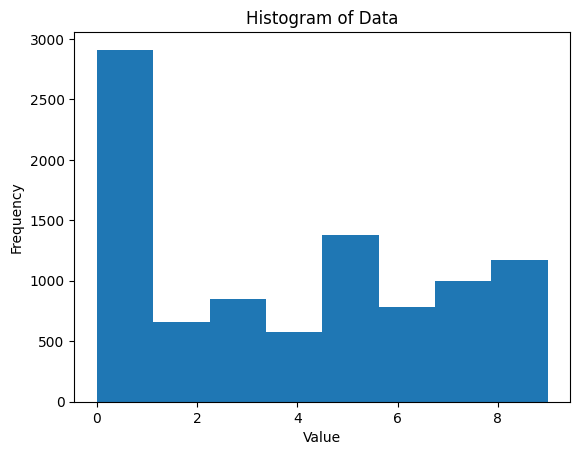

In [ ]:
plt.hist(cluster_labels, bins=8)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()

transition graph:

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# define the transition matrix
P = transition_matrix

# create a directed graph
G = nx.DiGraph()

# add nodes to the graph
for i in range(P.shape[0]):
    G.add_node(i)

# add edges to the graph
for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        if P[i,j] > 0:
            G.add_edge(i, j, weight=P[i,j])

# set the positions of the nodes in the graph
pos = nx.circular_layout(G)

# draw the nodes and edges of the graph
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)

# add edge labels to the graph
edge_labels = {(i, j): "{:.2f}".format(P[i,j]) for i, j in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# display the graph
plt.axis("off")
plt.show()


NameError: name 'transition_matrix' is not defined

In [ ]:
plt.plot(loss_list)
plt.title("Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, random_state=0)
embedded_3d = tsne.fit_transform(embeddings2)

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
embedded_2d = tsne.fit_transform(embeddings2)

In [ ]:
np.save('/content/drive/MyDrive/SocioSent/embedded_2d.npy', embedded_2d)
np.save('/content/drive/MyDrive/SocioSent/embedded_3d.npy', embedded_3d)

In [ ]:
embedded_3d = np.load('/content/drive/MyDrive/SocioSent/embedded_3d.npy')
embedded_2d = np.load('/content/drive/MyDrive/SocioSent/embedded_2d.npy')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/SocioSent/labels.csv', index_col=None, header=None, encoding="utf-8")

In [ ]:
import collections

labels = []#np.zeros([1,Xs.shape[1]])
embeds = []
embeds_3d = []
embeds_2d = []
n = 120
len = df.shape[0]
overlap = 0.5
step_size = 10
graph_of_frame = []

# count = collections.Counter(my_list)
# most_common = count.most_common(1)[0][0]

for i in range(0, 120):
  idx = 0
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[idx+2,:])
  embeds_2d.append(embedded_2d[idx+2,:])
  embeds_3d.append(embedded_3d[idx+2,:])
  graph_of_frame.append(idx)

for i in range(120, len-120):
  step = i // step_size
  idx = step - 4
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[idx+2,:])
  embeds_2d.append(embedded_2d[idx+2,:])
  embeds_3d.append(embedded_3d[idx+2,:])
  graph_of_frame.append(idx+2)

for i in range(len-120, len):
  # step = len - 120 // step_size
  idx = len - 120
  count = collections.Counter(cluster_labels[idx:idx+4])
  lab = 0 #count.most_common(1)[0][0]
  labels.append(lab)
  embeds.append(embeddings2[2,:])
  embeds_2d.append(embedded_2d[2,:])
  embeds_3d.append(embedded_3d[2,:])
  graph_of_frame.append(embedded_3d.shape[0])

# for _ in range(int(n*0.25)):
#     labels.append(cluster_labels[0])
#     embeds.append(embeddings2[0,:])

# for i in range(graph_num):
#   for _ in range(int(n*0.5)):
#     labels.append(cluster_labels[i])
#     embeds.append(embeddings2[i,:])

# for _ in range(int(50)):
#     labels.append(cluster_labels[graph_num-1])
#     embeds.append(embeddings2[graph_num-1,:])

  # labels[idx*n:(idx*n+n)] = la*np.ones([1,graph_num])
# labels[idx:idx+n] = la

embeds_3d = np.array(embeds_3d)
embeds_2d = np.array(embeds_2d)
graph_of_frame = np.array(graph_of_frame)

In [ ]:
print(labels[1000:1500])

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

In [ ]:
df = pd.DataFrame(labels)
df.to_csv('/content/labels.csv', index=False)

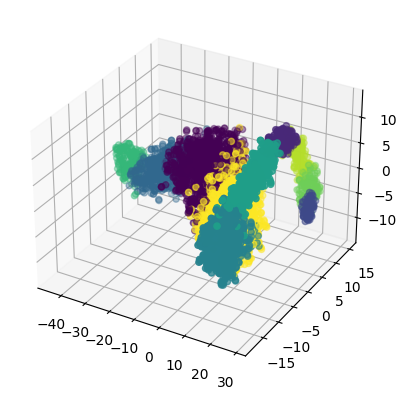

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# assume your embedded graphs are stored in a numpy array called 'embedded_graphs'
# with shape (6, 927)
embedded_graphs = embeddings2.T

# reduce the dimensionality of the embedded graphs to 3D using t-SNE
# tsne = TSNE(n_components=3, perplexity=30, random_state=0)
# embedded_3d = tsne.fit_transform(embedded_graphs.T)

# create a 3D scatter plot of the embedded graphs
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(embedded_3d[:,0], embedded_3d[:,1], embedded_3d[:,2], c=cluster_labels)
plt.show()


In [ ]:
embeds = np.array(embeds)

In [ ]:
np.savetxt('/content/embeds_3d.csv', embeds_3d, delimiter=',')
np.savetxt('/content/embeds_2d.csv', embeds_2d, delimiter=',')
# np.savetxt('/content/graph_of_frame.csv', graph_of_frame, delimiter=',')